In [8]:
import os
import tensorflow as tf

data_dir = "../data/cat_vs_dog_dataset/PetImages"
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"{num_skipped} images deleted.")

0 images deleted.


In [9]:
from tensorflow import keras

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,            
    image_size=(256, 256),     
    batch_size=32
)         

val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
Using 4682 files for validation.


['Cat', 'Dog']
Labels of first batch  :
[1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1]


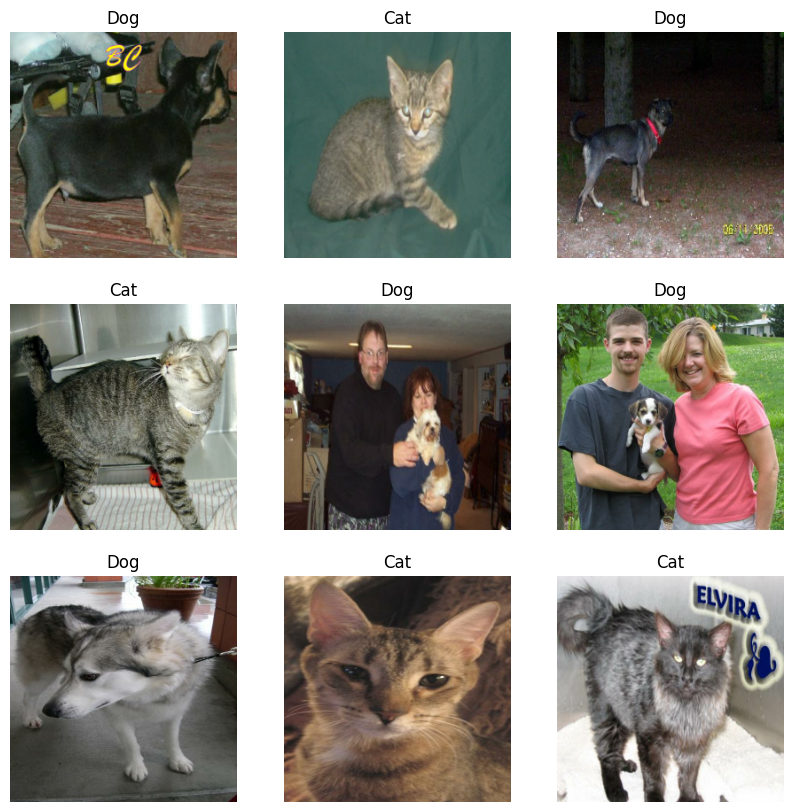

2026-02-11 11:08:11.368369: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
import matplotlib.pyplot as plt

print(train_ds.class_names) 

for images, labels in train_ds.take(1):
    print("Labels of first batch  :")
    print(labels.numpy()) 

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(train_ds.class_names[int(labels[i])])
        plt.axis("off")
    plt.show()

In [11]:
def normalize(image, label):
    # ensure float32 conversion before scaling
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

# Improve dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
# CNN model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, RandomFlip, RandomRotation, RandomZoom, Dropout, BatchNormalization

model = Sequential(
    [
        Input(shape=(256, 256, 3)),

        # Data Augmentation
        RandomFlip("horizontal"),
        RandomRotation(0.15),
        RandomZoom(0.15),

        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(padding='valid'),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(padding='valid'),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(padding='valid'),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(padding='valid'),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ]
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,787,393 (33.52 MB)

 Trainable params: 8,786,433 (33.52 MB)

 Non-trainable params: 960 (3.75 KB)

In [57]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
462/586 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.5079 - loss: 3.1883

KeyboardInterrupt: 

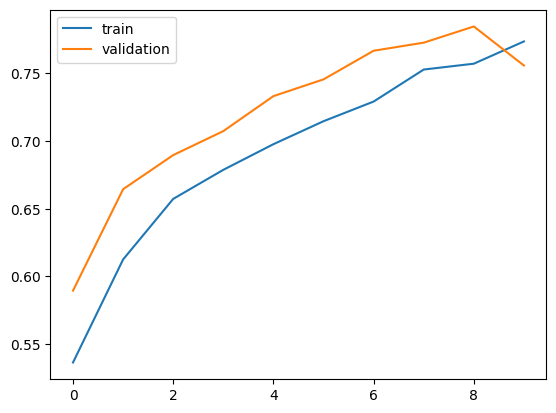

In [15]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

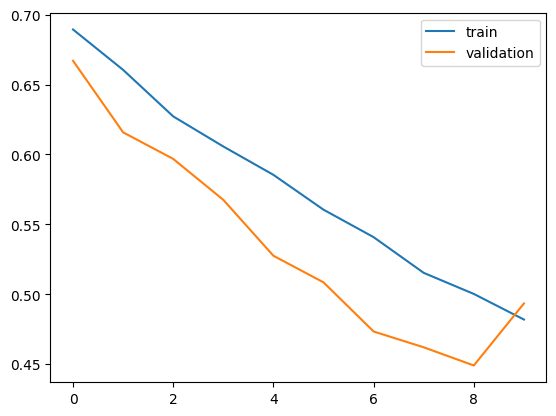

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [17]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

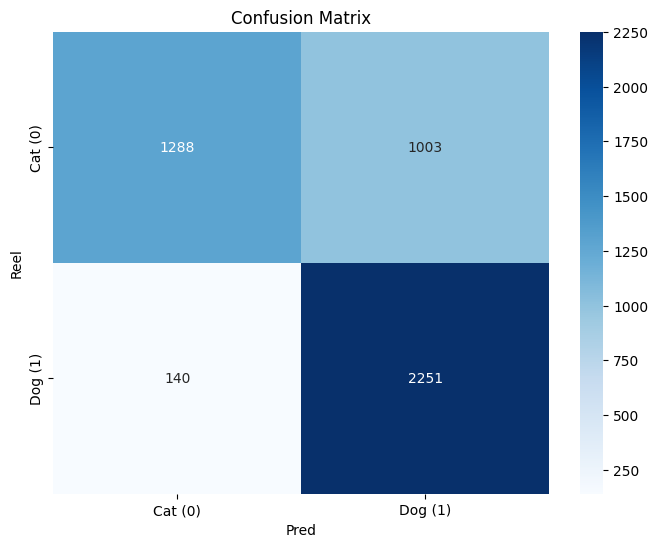

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat (0)', 'Dog (1)'], 
            yticklabels=['Cat (0)', 'Dog (1)'])
plt.xlabel('Pred')
plt.ylabel('Reel')
plt.title('Confusion Matrix')
plt.show()

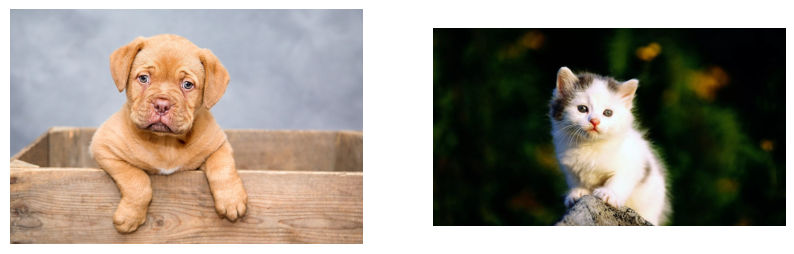

In [46]:
import cv2

dog_img = cv2.imread('./dog_img.jpg')
cat_img = cv2.imread('./cat_img.jpg')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [47]:
dog_img.shape

(853, 1280, 3)

In [48]:
cat_img.shape

(1080, 1920, 3)

In [49]:
dog_img = cv2.resize(dog_img, (256,256))
cat_img = cv2.resize(cat_img, (256,256))

In [50]:
test_input = dog_img.reshape((1, 256, 256, 3))
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[1.]], dtype=float32)

In [51]:
test_input = cat_img.reshape((1, 256, 256, 3))
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[1.]], dtype=float32)